In [55]:
import random
import networkx as nx
import matplotlib.pyplot as plt
import math
import pandas as pd
import numpy as np
import seaborn as sns
from timeit import default_timer as timer

In [2]:
def generar_grafo_comp(num_nodos):
    G = nx.Graph()
    for i in range(num_nodos):

        ubicacion = (random.uniform(0, 100), random.uniform(0, 100))

        if i == 0:
            ventana_inicio = 8
            ventana_fin = 9
        else:
            ventana_inicio = random.randint(9, 18)
            ventana_fin = ventana_inicio + random.randint(1, 2)
        G.add_node(i, ventana_tiempo=(ventana_inicio, ventana_fin), ubicacion=ubicacion)

    for u in G.nodes():
        for v in G.nodes():
            if u != v:
                distancia = calcular_distancia(G.nodes[u], G.nodes[v])
                G.add_edge(u, v, distancia=distancia)

    return G

def calcular_distancia(ubicacion1, ubicacion2):
    x1, y1 = ubicacion1['ubicacion']
    x2, y2 = ubicacion2['ubicacion']
    distancia = ((x2 - x1) ** 2 + (y2 - y1) ** 2) ** 0.5
    return math.floor(distancia)

def plot_graph_step(G, rastro, nodo_actual, pos):
    pos = {node: data['ubicacion'] for node, data in G.nodes(data=True)}
    plt.clf()
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500)
    for node, data in G.nodes(data=True):
        ventana_inicio, ventana_fin = data['ventana_tiempo']
        plt.text(data['ubicacion'][0], data['ubicacion'][1], f'{ventana_inicio}-{ventana_fin}', ha='center', va='bottom')
    path_edges = list(zip(rastro, rastro[1:]))
    nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='red', width=2)
    nx.draw_networkx_nodes(G, pos, nodelist=[nodo_actual], node_color='green', node_size=500)

    edge_labels = nx.get_edge_attributes(G, 'distancia')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.pause(0.5)

def calcular_costo_rastro(G, rastro):
    clientes_visitados = 0
    hora = 8
    distancia_total = 0
    tiempo_total = 0
    tiempo_espera_total = 0
    tiempo_viaje_total = 0

    for i in range(len(rastro) - 1):
        nodo_actual = rastro[i]
        nodo_sig = rastro[i + 1]
        distancia = G[nodo_actual][nodo_sig]['distancia']
        tiempo_viaje = round(distancia / 50,2)
        hora += tiempo_viaje

        inicio, fin = G.nodes[nodo_sig]['ventana_tiempo']
        if hora < inicio:
            tiempo_espera = inicio - hora
            tiempo_espera_total += tiempo_espera
            tiempo_total += tiempo_espera
        hora = inicio
        tiempo_total += tiempo_viaje
        distancia_total += distancia
        tiempo_viaje_total += tiempo_viaje
        clientes_visitados +=1

    return clientes_visitados-1, distancia_total, round(tiempo_total,2), round(tiempo_espera_total,2), round(tiempo_viaje_total,2)


def nearest_neightbor(G, plot=True):
    hora = 8.0
    nodo_inicial = 0

    pos = nx.spring_layout(G)
    plt.ion()
    plt.show()

    salir = 0
    nodos_novisitados = set(G.nodes)
    nodos_novisitados.remove(nodo_inicial)
    rastro = [nodo_inicial]
    nodo_actual = nodo_inicial

    hora += 1
    if plot:
        plot_graph_step(G, rastro, nodo_actual, pos)

    while nodos_novisitados:
        nodo_sig = min(nodos_novisitados, key=lambda node: G[nodo_actual][node]['distancia'])
        inicio, fin =  G.nodes[nodo_sig]['ventana_tiempo']
        tiempo_viaje = round(G[nodo_actual][nodo_sig]['distancia']/50,2)
        hora_llegada = hora + tiempo_viaje

        while (hora_llegada >= fin) and ((hora_llegada + 1) > fin):
            nodos_novisitados.remove(nodo_sig)
            if not nodos_novisitados:
                salir = 1
                break
            nodo_sig = min(nodos_novisitados, key=lambda node: G[nodo_actual][node]['distancia'])
            inicio, fin =  G.nodes[nodo_sig]['ventana_tiempo']
            tiempo_viaje = round(G[nodo_actual][nodo_sig]['distancia']/50,2)
            hora_llegada = hora + tiempo_viaje

        if salir == 1:
            break

        if hora_llegada < inicio:
            hora = inicio
        else:
            hora = hora_llegada
        if nodos_novisitados:
            nodos_novisitados.remove(nodo_sig)
        rastro.append(nodo_sig)
        nodo_actual = nodo_sig

        if plot:
            plot_graph_step(G, rastro, nodo_actual, pos)
        hora += 1

    rastro.append(nodo_inicial)
    if plot:
        plot_graph_step(G, rastro, nodo_actual, pos)

    print(f'Rastro Nearest Neighbor: {rastro}')
    clientes_visitados, distancia_total, tiempo_total, tiempo_espera_total, tiempo_viaje_total  = calcular_costo_rastro(G, rastro)
    porcentaje_tiempo_esperado = (tiempo_espera_total*100)/tiempo_total
    print(f'Clientes Visitados: {clientes_visitados}')
    print(f'Distancia Recorrida: {distancia_total}km')
    print(f'Tiempo Total: {tiempo_total} hrs')
    print(f'Tiempo de Espera Total : {tiempo_espera_total} hrs')
    print(f'Tiempo Viajando: {tiempo_viaje_total} hrs')
    print(f'{round(porcentaje_tiempo_esperado,2)}% del tiempo esperando')

    plt.ioff()
    plt.show()
    return clientes_visitados, distancia_total, tiempo_total, tiempo_espera_total, porcentaje_tiempo_esperado, tiempo_viaje_total



In [71]:
#tiempo a medida que aumenta el tamaño del grafo
tiempo = pd.DataFrame(columns=['clientes', 'tiempo_nn'])
tt = 0
for i in range(2,600):
    gr = generar_grafo_comp(i)
    inicio = timer()
    nearest_neightbor(gr, plot=False)
    fin =  timer()
    tt = fin-inicio
    print(tt)
    datos = [i, tt]
    tiempo.loc[i-2] = datos 
    print(i)
tiempo

Rastro Nearest Neighbor: [0, 1, 0]
Clientes Visitados: 1
Distancia Recorrida: 196km
Tiempo Total: 10.96 hrs
Tiempo de Espera Total : 7.04 hrs
Tiempo Viajando: 3.92 hrs
64.23% del tiempo esperando
0.0020985999872209504
2
Rastro Nearest Neighbor: [0, 2, 0]
Clientes Visitados: 1
Distancia Recorrida: 60km
Tiempo Total: 7.6 hrs
Tiempo de Espera Total : 6.4 hrs
Tiempo Viajando: 1.2 hrs
84.21% del tiempo esperando
0.0028311000060057268
3
Rastro Nearest Neighbor: [0, 1, 2, 0]
Clientes Visitados: 2
Distancia Recorrida: 93km
Tiempo Total: 3.54 hrs
Tiempo de Espera Total : 1.68 hrs
Tiempo Viajando: 1.86 hrs
47.46% del tiempo esperando
0.004117800010135397
4
Rastro Nearest Neighbor: [0, 4, 3, 0]
Clientes Visitados: 2
Distancia Recorrida: 133km
Tiempo Total: 8.04 hrs
Tiempo de Espera Total : 5.38 hrs
Tiempo Viajando: 2.66 hrs
66.92% del tiempo esperando
0.0029132000054232776
5
Rastro Nearest Neighbor: [0, 1, 0]
Clientes Visitados: 1
Distancia Recorrida: 18km
Tiempo Total: 9.18 hrs
Tiempo de Espera 

,clientes,tiempo_nn
0,2.0,0.002099
1,3.0,0.002831
2,4.0,0.004118
3,5.0,0.002913
4,6.0,0.003367
...,...,...
593,595.0,5.549312
594,596.0,5.573147
595,597.0,5.501372
596,598.0,5.649333


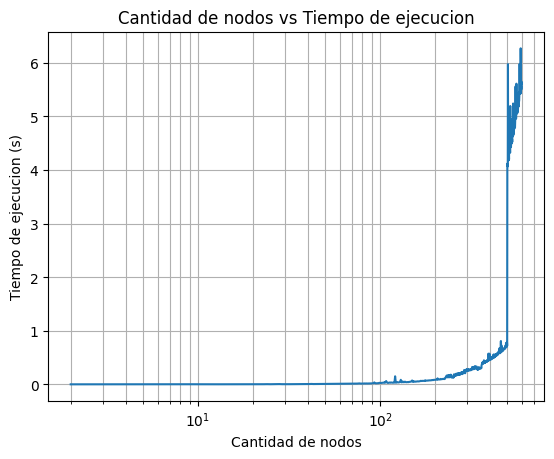

In [75]:
plt.grid(True, which='both')
plt.title("Cantidad de nodos vs Tiempo de ejecucion")
plt.semilogx(tiempo['clientes'], tiempo['tiempo_nn'])
plt.xlabel("Cantidad de nodos")
plt.ylabel("Tiempo de ejecucion (s)")
plt.show()

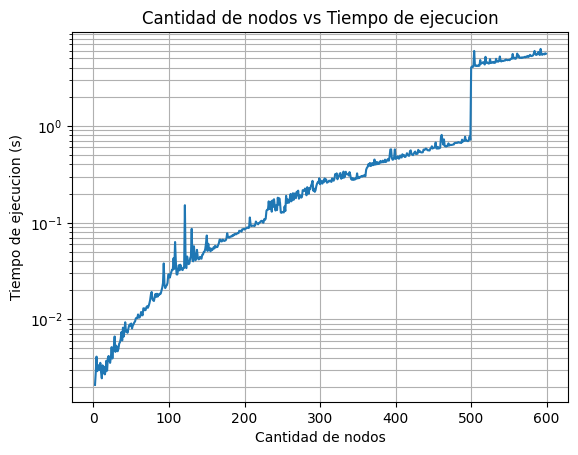

In [76]:
plt.grid(True, which='both')
plt.title("Cantidad de nodos vs Tiempo de ejecucion")
plt.semilogy(tiempo['clientes'], tiempo['tiempo_nn'])
plt.xlabel("Cantidad de nodos")
plt.ylabel("Tiempo de ejecucion (s)")
plt.show()

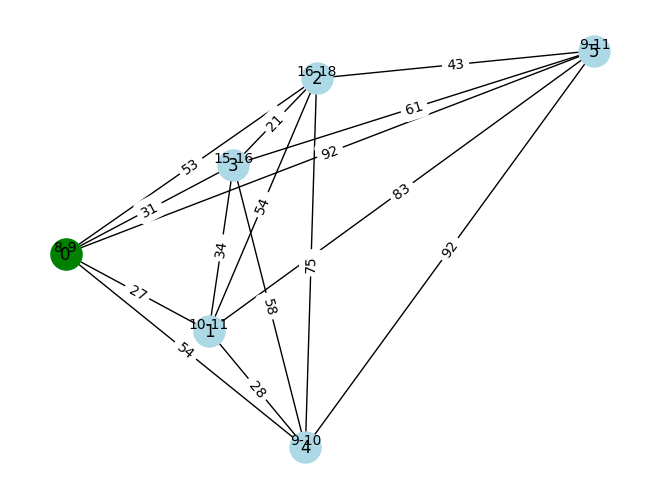

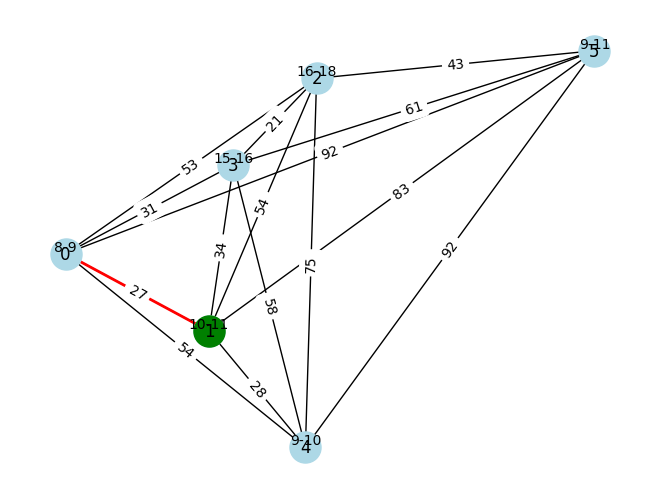

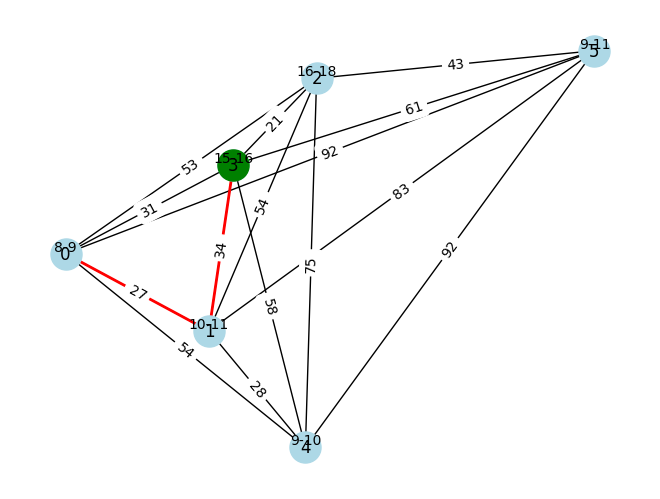

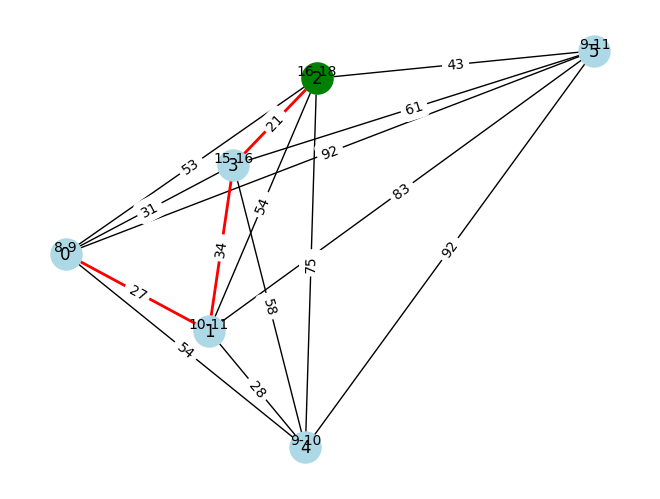

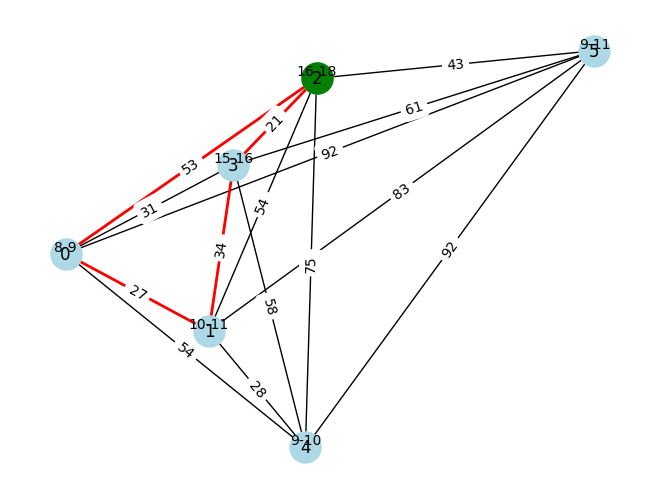

Rastro Nearest Neighbor: [0, 1, 3, 2, 0]
Clientes Visitados: 3
Distancia Recorrida: 135km
Tiempo Total: 9.06 hrs
Tiempo de Espera Total : 6.36 hrs
Tiempo Viajando: 2.7 hrs
70.2% del tiempo esperando


(3, 135, 9.06, 6.36, 70.19867549668874, 2.7)

In [26]:
grafo = generar_grafo_comp(6)
nearest_neightbor(grafo)

In [73]:
data = pd.DataFrame(columns=['clientes','distancia_recorrida','tiempo_total','tiempo_espera','porcentaje_espera','tiempo_viajando'])
for i in range(500):
  G = generar_grafo_comp(200)
  resultado = nearest_neightbor(G, plot=False)
  data.loc[i] = resultado
data

Rastro Nearest Neighbor: [0, 123, 26, 95, 139, 0]
Clientes Visitados: 4
Distancia Recorrida: 80km
Tiempo Total: 11.28 hrs
Tiempo de Espera Total : 9.68 hrs
Tiempo Viajando: 1.6 hrs
85.82% del tiempo esperando
Rastro Nearest Neighbor: [0, 108, 154, 140, 171, 0]
Clientes Visitados: 4
Distancia Recorrida: 50km
Tiempo Total: 9.7 hrs
Tiempo de Espera Total : 8.7 hrs
Tiempo Viajando: 1.0 hrs
89.69% del tiempo esperando
Rastro Nearest Neighbor: [0, 37, 65, 112, 164, 11, 47, 0]
Clientes Visitados: 6
Distancia Recorrida: 77km
Tiempo Total: 10.7 hrs
Tiempo de Espera Total : 9.16 hrs
Tiempo Viajando: 1.54 hrs
85.61% del tiempo esperando
Rastro Nearest Neighbor: [0, 112, 182, 10, 195, 0]
Clientes Visitados: 4
Distancia Recorrida: 79km
Tiempo Total: 11.18 hrs
Tiempo de Espera Total : 9.6 hrs
Tiempo Viajando: 1.58 hrs
85.87% del tiempo esperando
Rastro Nearest Neighbor: [0, 21, 9, 113, 56, 0]
Clientes Visitados: 4
Distancia Recorrida: 80km
Tiempo Total: 10.9 hrs
Tiempo de Espera Total : 9.3 hrs
Tiem

,clientes,distancia_recorrida,tiempo_total,tiempo_espera,porcentaje_espera,tiempo_viajando
0,4.0,80.0,11.28,9.68,85.815603,1.60
1,4.0,50.0,9.70,8.70,89.690722,1.00
2,6.0,77.0,10.70,9.16,85.607477,1.54
3,4.0,79.0,11.18,9.60,85.867621,1.58
4,4.0,80.0,10.90,9.30,85.321101,1.60
...,...,...,...,...,...,...
495,6.0,73.0,10.92,9.46,86.630037,1.46
496,2.0,58.0,11.10,9.94,89.549550,1.16
497,3.0,35.0,10.60,9.90,93.396226,0.70
498,5.0,70.0,11.02,9.62,87.295826,1.40


In [37]:
data.describe()

,clientes,distancia_recorrida,tiempo_total,tiempo_espera,porcentaje_espera,tiempo_viajando
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.00000
mean,3.726000,66.852000,10.788720,9.451680,87.762967,1.33704
std,1.232055,29.360009,0.516303,0.415584,4.958190,0.58720
min,1.000000,4.000000,9.200000,7.800000,68.541301,0.08000
25%,3.000000,46.750000,10.480000,9.280000,84.900686,0.93500
50%,4.000000,64.500000,10.760000,9.560000,88.093055,1.29000
75%,4.000000,83.000000,11.085000,9.760000,91.071369,1.66000
max,8.000000,193.000000,12.600000,10.000000,99.203187,3.86000


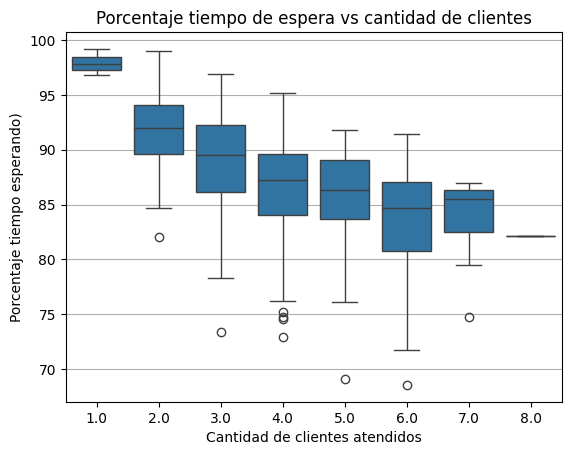

In [61]:
plt.grid(True, which='both')
plt.title("Porcentaje tiempo de espera vs cantidad de clientes")
sns.boxplot(x='clientes', y='porcentaje_espera', data=data)
plt.xlabel("Cantidad de clientes atendidos")
plt.ylabel("Porcentaje tiempo esperando)")
plt.show()

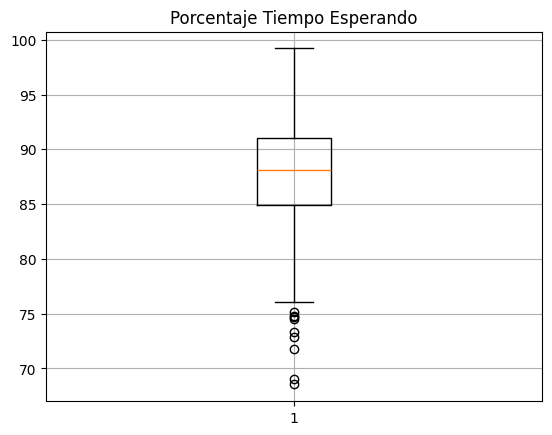

In [68]:
plt.grid(True, which='both')
plt.title("Porcentaje Tiempo Esperando")   
plt.boxplot(data['porcentaje_espera'])
plt.show()

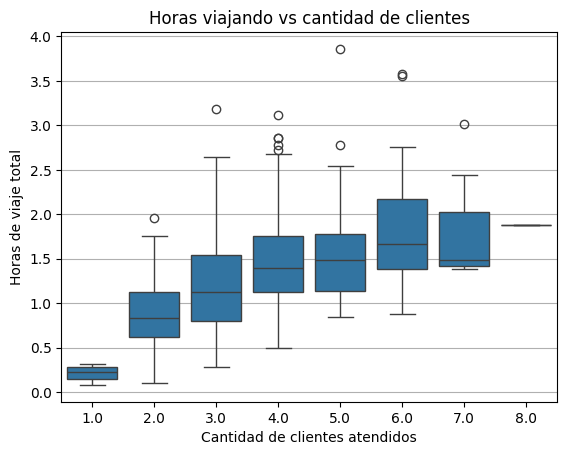

In [62]:
plt.grid(True, which='both')
plt.title("Horas viajando vs cantidad de clientes")
sns.boxplot(x='clientes', y='tiempo_viajando', data=data)
plt.xlabel("Cantidad de clientes atendidos")
plt.ylabel("Horas de viaje total")
plt.show()

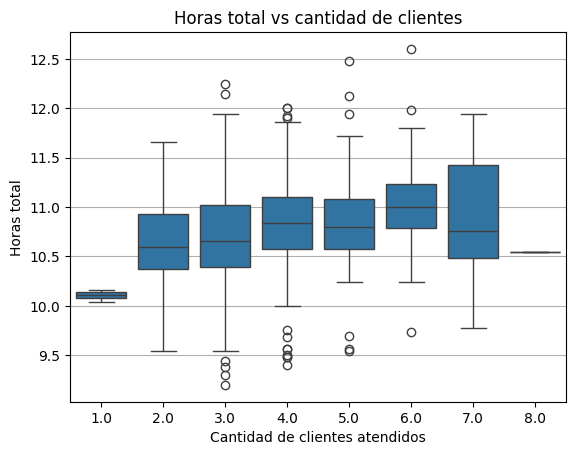

In [70]:
plt.grid(True, which='both')
plt.title("Horas total vs cantidad de clientes")
sns.boxplot(x='clientes', y='tiempo_total', data=data)
plt.xlabel("Cantidad de clientes atendidos")
plt.ylabel("Horas total")
plt.show()